In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
import kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'
kaggle.api.authenticate()
kaggle.api.dataset_download_files('abdunnoor11/bpl-data', unzip=True)

# Bangladesh Premier League Analysis

- Dataset from Kaggle [Link](https://www.kaggle.com/abdunnoor11/bpl-data)

In [4]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [5]:
df = pd.read_csv('/content/bpl.csv')
print(df.shape)
df.head(2)

(311, 19)


,id,season,match_no,date,team_1,team_1_score,team_2,team_2_score,player_of_match,toss_winner,toss_decision,winner,venue,city,win_by_wickets,win_by_runs,result,umpire_1,umpire_2
0,0,2011/12,Final,Feb 29 2012,Barisal Burners,140/7,Dhaka Gladiators,144/2,Imran Nazir,Dhaka Gladiators,field first,Dhaka,"Shere Bangla National Stadium, Mirpur",Mirpur,8,0,8 wickets,David Orchard,Enamul Haque
1,30,2011/12,3rd,Feb 11 2012,Khulna Royal Bengals,175/5,Dhaka Gladiators,156/7,Andre Russell,Khulna Royal Bengals,bat first,Khulna,"Shere Bangla National Stadium, Mirpur",Mirpur,0,19,19 runs,Jeremy Lloyds,Sharfuddoula


In [6]:
print(df['winner'].unique())

['Dhaka' 'Khulna' 'Barisal' 'Chittagong' 'Rajshahi' 'Vikings' 'Dynamites'
 'Titans' 'Riders' 'Bulls' 'Kings' 'Victorians' 'Sixers' 'Match' 'Super'
 'Challengers' 'Warriors' 'Royals' 'Platoon' 'Tigers' 'Thunder' 'Rangers'
 'Barishal' 'Sunrisers']


In [7]:
print(df['venue'].unique())

['Shere Bangla National Stadium, Mirpur'
 'Zahur Ahmed Chowdhury Stadium, Chittagong'
 'Sylhet International Cricket Stadium'
 'Zahur Ahmed Chowdhury Stadium, Chattogram'
 'Sheikh Abu Naser Stadium, Khulna' 'MA Aziz Stadium, Chittagong']


In [8]:
print(df['city'].unique())

['Mirpur' 'Chittagong' 'Stadium' 'Chattogram' 'Khulna']


In [9]:
uniqueTeamNames = list(df['team_1'].unique())
uniqueTeamNames2 = list(df['team_2'].unique())

print('Team 1\n', uniqueTeamNames)
print('\nTeam 2\n', uniqueTeamNames2)

Team 1
 ['Barisal Burners', 'Khulna Royal Bengals', 'Chittagong Kings', 'Sylhet Royals', 'Dhaka Gladiators', 'Duronto Rajshahi', 'Chittagong Vikings', 'Barisal Bulls', 'Khulna Titans', 'Comilla Victorians', 'Dhaka Dynamites', 'Rangpur Riders', 'Rajshahi Kings', 'Sylhet Sixers', 'Sylhet Super Stars', 'Sylhet Thunder', 'Cumilla Warriors', 'Dhaka Platoon', 'Rangpur Rangers', 'Chattogram Challengers', 'Rajshahi Royals', 'Khulna Tigers', 'Minister Group Dhaka', 'Sylhet Sunrisers', 'Fortune Barishal']

Team 2
 ['Dhaka Gladiators', 'Khulna Royal Bengals', 'Duronto Rajshahi', 'Chittagong Kings', 'Barisal Burners', 'Sylhet Royals', 'Comilla Victorians', 'Dhaka Dynamites', 'Rajshahi Kings', 'Rangpur Riders', 'Barisal Bulls', 'Chittagong Vikings', 'Khulna Titans', 'Sylhet Sixers', 'Sylhet Super Stars', 'Chattogram Challengers', 'Rangpur Rangers', 'Rajshahi Royals', 'Cumilla Warriors', 'Khulna Tigers', 'Sylhet Thunder', 'Dhaka Platoon', 'Fortune Barishal', 'Minister Group Dhaka', 'Sylhet Sunrisers

In [10]:
for i in uniqueTeamNames2:
  if i not in uniqueTeamNames:
    uniqueTeamNames.append(i)

print('All unique teams\n', uniqueTeamNames)

All unique teams
 ['Barisal Burners', 'Khulna Royal Bengals', 'Chittagong Kings', 'Sylhet Royals', 'Dhaka Gladiators', 'Duronto Rajshahi', 'Chittagong Vikings', 'Barisal Bulls', 'Khulna Titans', 'Comilla Victorians', 'Dhaka Dynamites', 'Rangpur Riders', 'Rajshahi Kings', 'Sylhet Sixers', 'Sylhet Super Stars', 'Sylhet Thunder', 'Cumilla Warriors', 'Dhaka Platoon', 'Rangpur Rangers', 'Chattogram Challengers', 'Rajshahi Royals', 'Khulna Tigers', 'Minister Group Dhaka', 'Sylhet Sunrisers', 'Fortune Barishal']


In [11]:
len(uniqueTeamNames)

25

In [12]:
winTeams = list(df['winner'].unique())

for i in winTeams:
  if i not in uniqueTeamNames:
    uniqueTeamNames.append(i)

print(len(uniqueTeamNames))

49


## Let's Analyze the whole dataset of BPL

### Function to plot the bar graph

In [13]:
def plotGraph(dictionary, col):
  # sort the dictionary in descending order by frequency
  dictionary = dict(sorted(dictionary.items(),
                           key=operator.itemgetter(1),
                           reverse=True))

  print(f'Dictionary of {col} in descending order by value: ', dictionary)

  # extracting top 5 elements of the dictionary
  top5Data = dict()
  j = 0

  for i in dictionary:
    top5Data[i] = dictionary[i]
    j += 1
    if j == 5:
      break

  # segregate names and values of the top 5 elements
  names = list(top5Data.keys())
  values = list(top5Data.values())

  print(f'Names of the top 5 {col} elements: ', names)
  print(f'Values of the top 5 {col} elements: ', values)

  # Now, plot the graph for the same
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(10)

  c = ['red', 'yellow', 'black', 'blue', 'orange']
  plt.bar(range(len(top5Data)), values, tick_label=names, color=c)
  plt.show()

### Function to analyze data of Bangladesh Premier League Analysis

In [14]:
def analyzeData(dataFrame, col):
  dictionary = dict()

  # enlist all the unique data and count their frequency
  for i in dataFrame[col]:
    if i not in dictionary:
      dictionary[i] = 1
    else:
      dictionary[i] += 1

  # function call to plot the graph
  plotGraph(dictionary, col)

### Let's Start to Analyze Datasets w.r.t. Player Name.

Dictionary of player_of_match in descending order by value:  {'Shakib Al Hasan': 11, 'Mahmudullah': 9, 'Chris Gayle': 7, 'Mushfiqur Rahim': 7, 'Shahid Afridi': 7, 'Ravi Bopara': 7, 'Andre Russell': 6, 'Tamim Iqbal': 6, 'Evin Lewis': 6, 'Azhar Mahmood': 5, 'Dawid Malan': 5, 'Daren Sammy': 5, 'Mahedi Hasan': 5, 'Jahurul Islam': 5, 'Ahmed Shehzad': 4, 'Dwayne Bravo': 4, 'Marlon Samuels': 4, 'Mohammad Nabi': 4, 'Shoaib Malik': 4, 'Robbie Frylinck': 4, 'Rilee Rossouw': 4, 'Imrul Kayes': 4, 'Mehedi Hasan Rana': 4, 'Brad Hodge': 4, 'Anamul Haque': 3, 'Mohammad Shahzad': 3, 'Thisara Perera': 3, 'Samit Patel': 3, 'Mosharraf Hossain': 3, 'Shafiul Islam': 3, 'Sohail Tanvir': 3, 'Mohammad Saifuddin': 3, 'Mehidy Hasan Miraz': 3, 'Mashrafe Mortaza': 3, 'Litton Das': 3, 'Mustafizur Rahman': 3, 'Upul Tharanga': 3, 'Al-Amin Hossain': 3, 'Andre Fletcher': 3, 'Lewis Gregory': 3, 'Nasir Hossain': 3, 'Paul Stirling': 3, 'Imran Nazir': 2, 'Nasir Jamshed': 2, 'Mehedi Maruf': 2, 'Sabbir Rahman': 2, 'Mohammad 

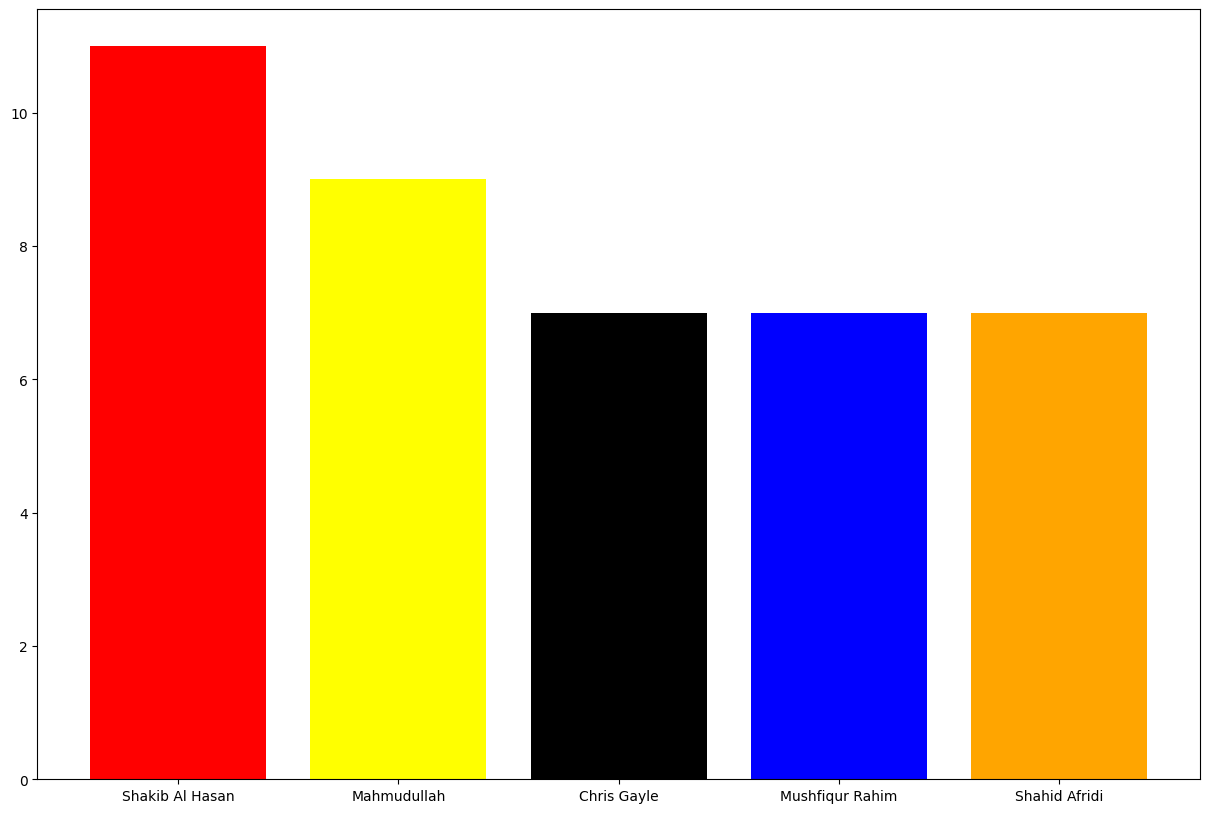

In [15]:
# Let's analyse the data for Man of the Match
analyzeData(df, 'player_of_match')

Dictionary of umpire_1 in descending order by value:  {'Mahfuzur Rahman': 41, 'Masudur Rahman': 31, 'Enamul Haque': 29, 'Anisur Rahman': 26, 'Gazi Sohel': 22, 'Nadir Shah': 21, 'Alex Wharf': 19, 'David Millns': 18, 'Khalid Mahmood': 16, 'David Orchard': 15, 'Jeremy Lloyds': 14, 'Morshed Ali Khan': 10, 'Ranmore Martinesz': 9, 'Prageeth Rambukwella': 8, 'Ahsan Raza': 7, 'Sharfuddoula': 6, 'Riazuddin': 3, 'Khalid Mahmud': 2, 'D Milns': 2, 'Akteruzzaman': 2, 'Nahidul Islam': 1, 'Abdul Mazid': 1, 'Habibur Rahman': 1, 'Shozab Raza': 1, 'Minhajul Abedin Afridi': 1, 'Dawid Malan': 1, 'Moniruzzaman': 1, 'Nayeem Hasan': 1, 'Bishawnath Halder': 1, 'Amit Kumar': 1}
Names of the top 5 umpire_1 elements:  ['Mahfuzur Rahman', 'Masudur Rahman', 'Enamul Haque', 'Anisur Rahman', 'Gazi Sohel']
Values of the top 5 umpire_1 elements:  [41, 31, 29, 26, 22]


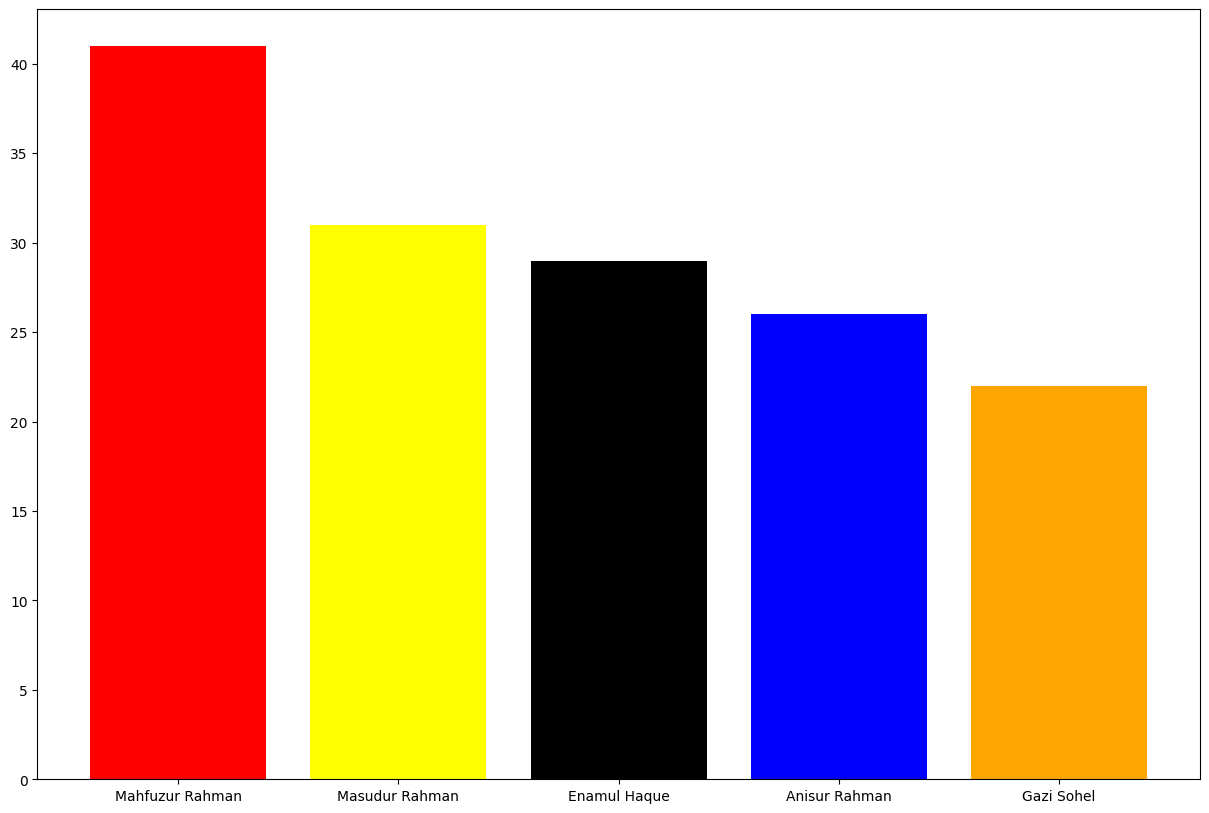

In [16]:
# Let's analyse data for umpire1
analyzeData(df, 'umpire_1')

Dictionary of umpire_2 in descending order by value:  {'Ranmore Martinesz': 50, 'Sharfuddoula': 39, 'Tanvir Ahmed': 36, 'Masudur Rahman': 32, 'Jeremy Lloyds': 19, 'Prageeth Rambukwella': 18, 'Riazuddin': 18, 'Nadir Shah': 16, 'Mahfuzur Rahman': 16, 'Richard Illingworth': 14, 'Gazi Sohel': 12, 'Morshed Ali Khan': 12, 'Enamul Haque': 6, 'Shozab Raza': 6, 'Rashid Riaz': 3, 'Khalid Mahmood': 2, 'David Orchard': 1, 'Najmul Hossain Shanto': 1, 'Mehidy Hasan Miraz': 1, 'Shohidul Islam': 1, 'Sanjit Saha': 1, 'Afif Hossain': 1, 'Shafiuddin Ahmed': 1, 'Qazi Onik': 1, 'Moniruzzaman': 1, 'Raveendra Wimalasiri': 1, 'Jubair Ahmed': 1, 'Mehedi Maruf': 1}
Names of the top 5 umpire_2 elements:  ['Ranmore Martinesz', 'Sharfuddoula', 'Tanvir Ahmed', 'Masudur Rahman', 'Jeremy Lloyds']
Values of the top 5 umpire_2 elements:  [50, 39, 36, 32, 19]


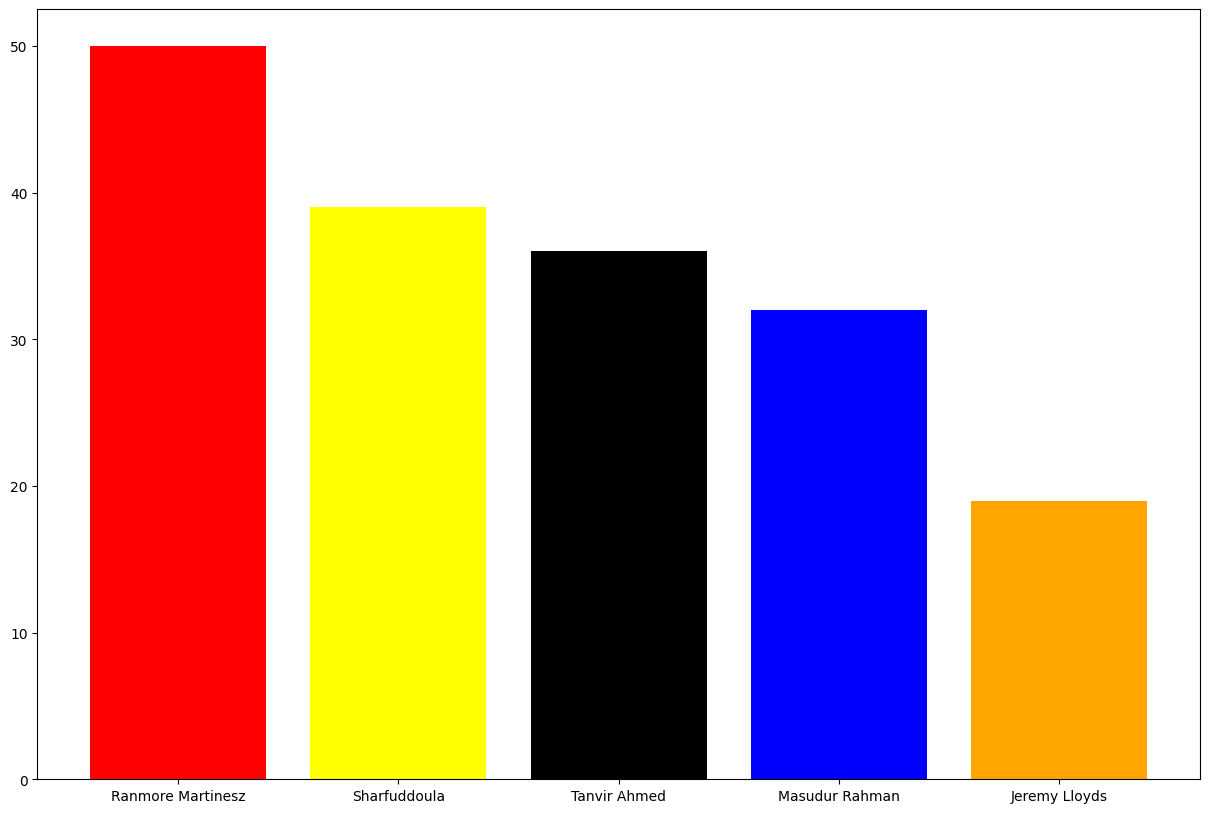

In [17]:
# Let's analyse data for umpire2
analyzeData(df, 'umpire_2')

Dictionary of toss_winner in descending order by value:  {'Rangpur Riders': 34, 'Comilla Victorians': 27, 'Dhaka Dynamites': 25, 'Rajshahi Kings': 22, 'Khulna Titans': 21, 'Chittagong Vikings': 21, 'Dhaka Gladiators': 15, 'Barisal Burners': 13, 'Khulna Tigers': 13, 'Khulna Royal Bengals': 12, 'Sylhet Royals': 12, 'Duronto Rajshahi': 11, 'Barisal Bulls': 11, 'Sylhet Sixers': 11, 'Chittagong Kings': 10, 'Rajshahi Royals': 9, 'Chattogram Challengers': 8, 'Cumilla Warriors': 8, 'Rangpur Rangers': 6, 'Sylhet Super Stars': 5, 'Sylhet Thunder': 5, 'Fortune Barishal': 4, 'Dhaka Platoon': 3, 'Minister Group Dhaka': 3, 'Sylhet Sunrisers': 2}
Names of the top 5 toss_winner elements:  ['Rangpur Riders', 'Comilla Victorians', 'Dhaka Dynamites', 'Rajshahi Kings', 'Khulna Titans']
Values of the top 5 toss_winner elements:  [34, 27, 25, 22, 21]


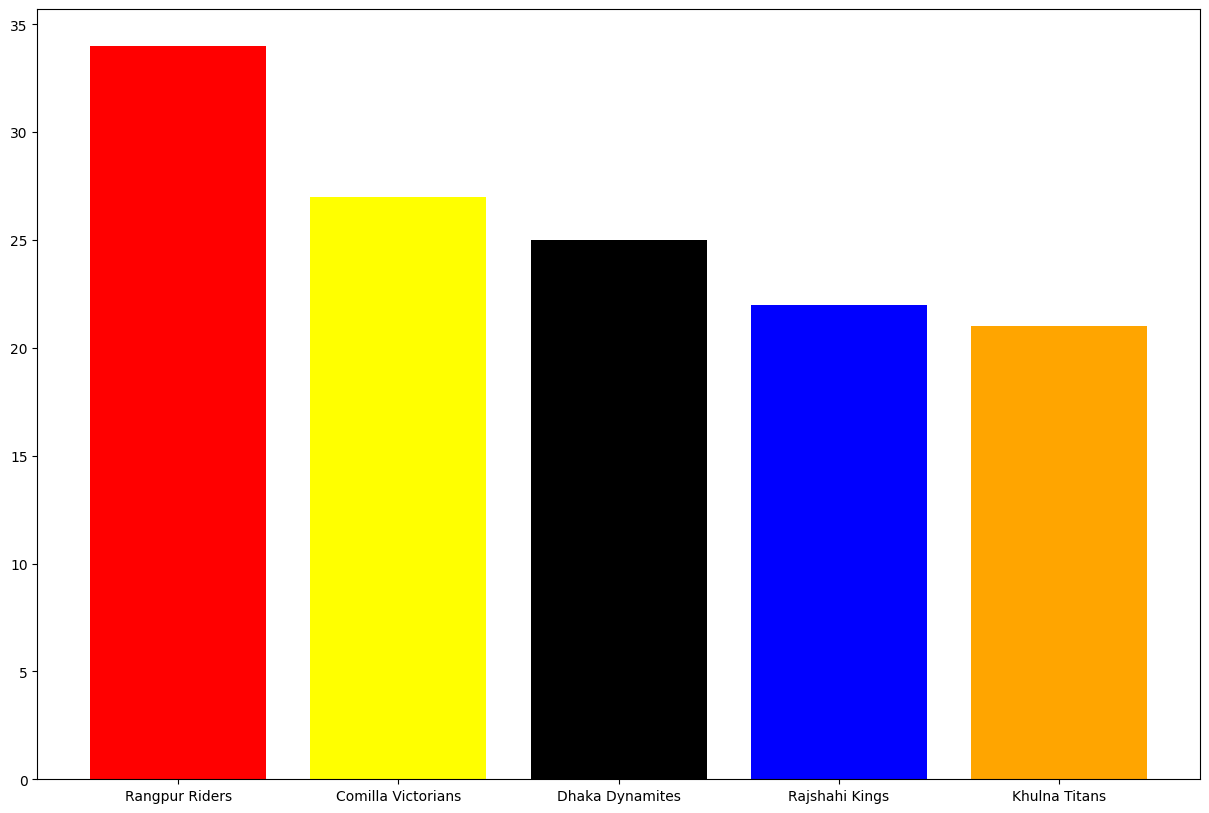

In [18]:
# Let's analyse data for toss-winner
analyzeData(df, 'toss_winner')

Dictionary of toss_decision in descending order by value:  {'field first': 208, 'bat first': 103}
Names of the top 5 toss_decision elements:  ['field first', 'bat first']
Values of the top 5 toss_decision elements:  [208, 103]


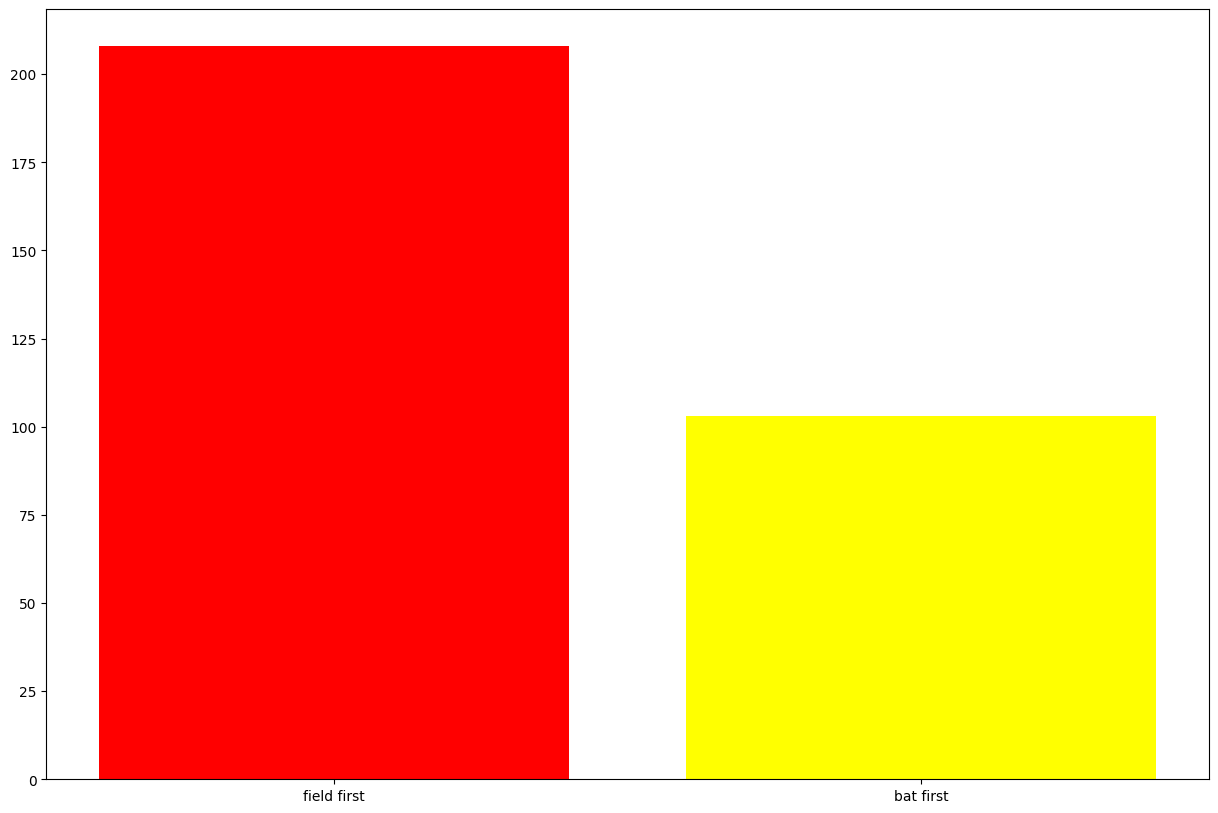

In [19]:
# Let's analyse data for Toss Decision
analyzeData(df, 'toss_decision')

## Analyzing dataset of Bats Man

In [20]:
df2 = pd.read_csv('/content/batsman.csv')
print(df2.shape)
df2.head()

(5048, 12)


,id,season,match_no,date,player_name,comment,R,B,M,fours,sixs,SR
0,31,2011/12,2nd,Feb 10 2012,Tamim Iqbal,c Samuels b Mohammad Sami,3,7,10,0,0,42.85
1,31,2011/12,2nd,Feb 10 2012,Jahurul Islam,c †Mushfiqur Rahim b Ervine,11,13,21,0,1,84.61
2,0,2011/12,Final,Feb 29 2012,Ahmed Shehzad,NaN,28,20,21,3,1,140.00
3,30,2011/12,3rd,Feb 11 2012,Shivnarine Chanderpaul,b Azhar Mahmood,19,15,24,2,1,126.66
4,29,2011/12,4th,Feb 11 2012,Ahmed Shehzad,c Syed Rasel b Abdul Razzaq,67,40,62,4,6,167.50


### Function to analyze data of Bats Man

In [21]:
def analyzeBatsMan(dataFrame, col):
  dictionary = dict()

  # enlist all the unique data and count their frequency
  for i in dataFrame.index:
    if len(dataFrame[col][i]) > 0:
      if dataFrame[col][i] != '-':
        val = int(dataFrame[col][i])
        if dataFrame['player_name'][i] not in dictionary:
          dictionary[dataFrame['player_name'][i]] = val
        else:
          dictionary[dataFrame['player_name'][i]] += val

  print('Length of the dictionary: ', len(dictionary))

  # function call to plot the graph
  plotGraph(dictionary, col)

### Let's Start to Analyze Datasets w.r.t. Player Name.

Length of the dictionary:  372
Dictionary of R in descending order by value:  {'Tamim Iqbal': 2483, 'Mushfiqur Rahim': 2408, 'Mahmudullah': 2014, 'Imrul Kayes': 1909, 'Sabbir Rahman': 1710, 'Anamul Haque': 1676, 'Mohammad Mithun': 1627, 'Shakib Al Hasan': 1620, 'Chris Gayle': 1599, 'Mominul Haque': 1327, 'Rilee Rossouw': 1240, 'Litton Das': 1196, 'Nasir Hossain': 1085, 'Jahurul Islam': 1065, 'Ravi Bopara': 1055, 'Shoaib Malik': 1045, 'Marlon Samuels': 1039, 'Soumya Sarkar': 993, 'Shahriar Nafees': 976, 'Najmul Hossain Shanto': 967, 'Mosaddek Hossain': 957, 'Junaid Siddique': 955, 'Evin Lewis': 945, 'Andre Fletcher': 940, 'Ahmed Shehzad': 937, 'Afif Hossain': 928, 'Shamsur Rahman': 910, 'Mohammad Shahzad': 834, 'Kumar Sangakkara': 827, 'Dawid Malan': 815, 'Andre Russell': 812, 'Thisara Perera': 812, 'Nurul Hasan': 791, 'Ryan ten Doeschate': 780, 'Ariful Haque': 760, 'Brad Hodge': 756, 'Lendl Simmons': 755, 'Rony Talukdar': 733, 'Ziaur Rahman': 720, 'Mehidy Hasan Miraz': 708, 'Kieron Pol

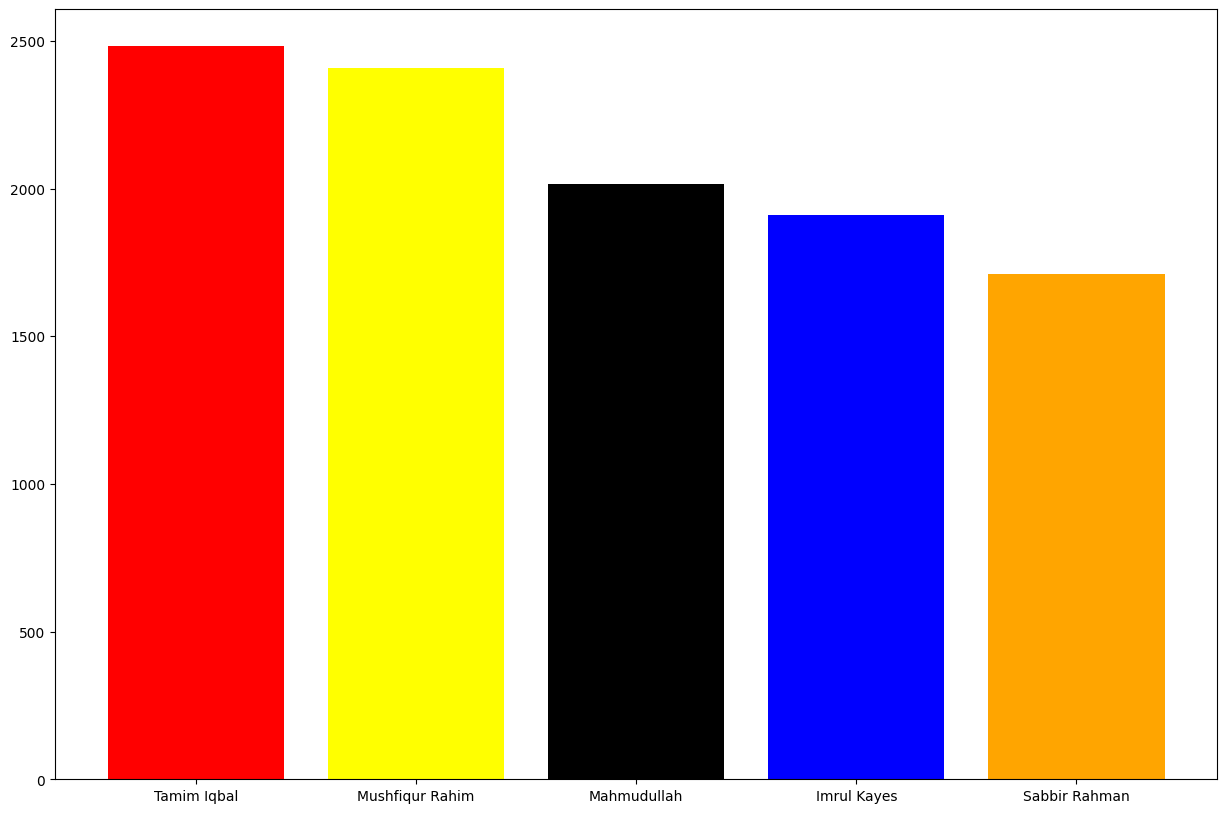

In [22]:
# Let's analyze data for scores players
analyzeBatsMan(df2, 'R')

Length of the dictionary:  372
Dictionary of fours in descending order by value:  {'Tamim Iqbal': 258, 'Mushfiqur Rahim': 201, 'Imrul Kayes': 168, 'Shakib Al Hasan': 154, 'Mahmudullah': 153, 'Anamul Haque': 147, 'Sabbir Rahman': 136, 'Mominul Haque': 128, 'Litton Das': 124, 'Chris Gayle': 108, 'Rilee Rossouw': 108, 'Shahriar Nafees': 106, 'Soumya Sarkar': 105, 'Mohammad Mithun': 102, 'Junaid Siddique': 101, 'Andre Fletcher': 99, 'Mohammad Shahzad': 94, 'Afif Hossain': 92, 'Marlon Samuels': 91, 'Ahmed Shehzad': 90, 'Kumar Sangakkara': 89, 'Jahurul Islam': 88, 'Najmul Hossain Shanto': 87, 'Evin Lewis': 85, 'Nasir Hossain': 84, 'Shoaib Malik': 83, 'Brad Hodge': 79, 'Lendl Simmons': 79, 'Ravi Bopara': 79, 'Mosaddek Hossain': 78, 'Shamsur Rahman': 77, 'Rony Talukdar': 75, 'Mehidy Hasan Miraz': 71, 'Dawid Malan': 69, 'Dwayne Smith': 68, 'Nurul Hasan': 66, 'Mohammad Ashraful': 65, 'Thisara Perera': 64, 'Brendan Taylor': 63, 'Azhar Mahmood': 58, 'Dilshan Munaweera': 58, 'Mehedi Maruf': 56, 'Pa

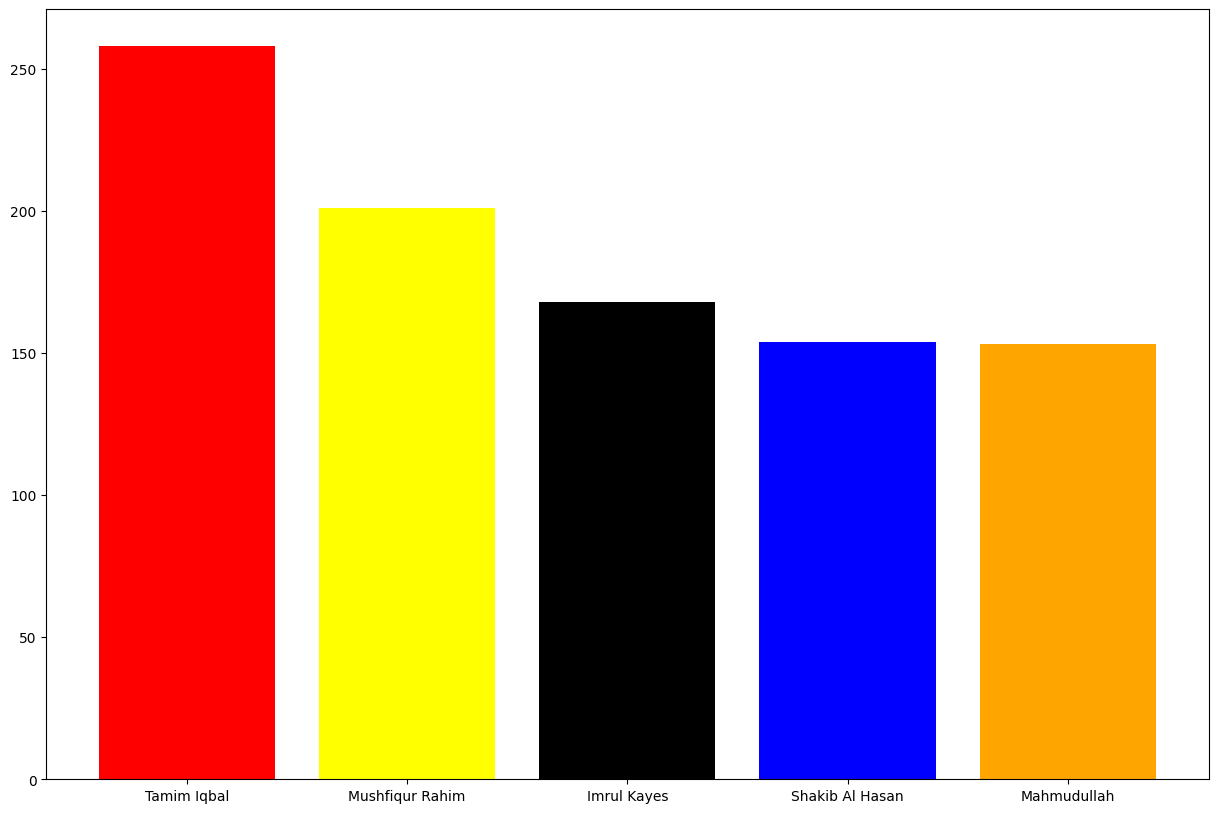

In [23]:
# Let's analyse data for score - fours
analyzeBatsMan(df2, 'fours')

Length of the dictionary:  372
Dictionary of sixs in descending order by value:  {'Chris Gayle': 139, 'Tamim Iqbal': 80, 'Imrul Kayes': 80, 'Mushfiqur Rahim': 75, 'Mahmudullah': 74, 'Sabbir Rahman': 70, 'Andre Russell': 67, 'Mohammad Mithun': 61, 'Anamul Haque': 58, 'Evin Lewis': 57, 'Rilee Rossouw': 55, 'Kieron Pollard': 48, 'Ziaur Rahman': 46, 'Shakib Al Hasan': 45, 'Thisara Perera': 45, 'Nicholas Pooran': 41, 'Andre Fletcher': 39, 'Afif Hossain': 39, 'Marlon Samuels': 38, 'Shahid Afridi': 38, 'Litton Das': 38, 'Shoaib Malik': 38, 'Cameron Delport': 37, 'Daren Sammy': 34, 'Ryan ten Doeschate': 34, 'Ahmed Shehzad': 33, 'Junaid Siddique': 33, 'Mohammad Shahzad': 33, 'Nasir Hossain': 33, 'Dawid Malan': 33, 'Mashrafe Mortaza': 33, 'Brad Hodge': 32, 'Dwayne Smith': 32, 'Johnson Charles': 31, 'Lendl Simmons': 31, 'Soumya Sarkar': 31, 'Yasir Ali': 29, 'Mosaddek Hossain': 29, 'Shamsur Rahman': 29, 'Mominul Haque': 28, 'Sunil Narine': 28, 'Jahurul Islam': 27, 'Najmul Hossain Shanto': 27, 'Rav

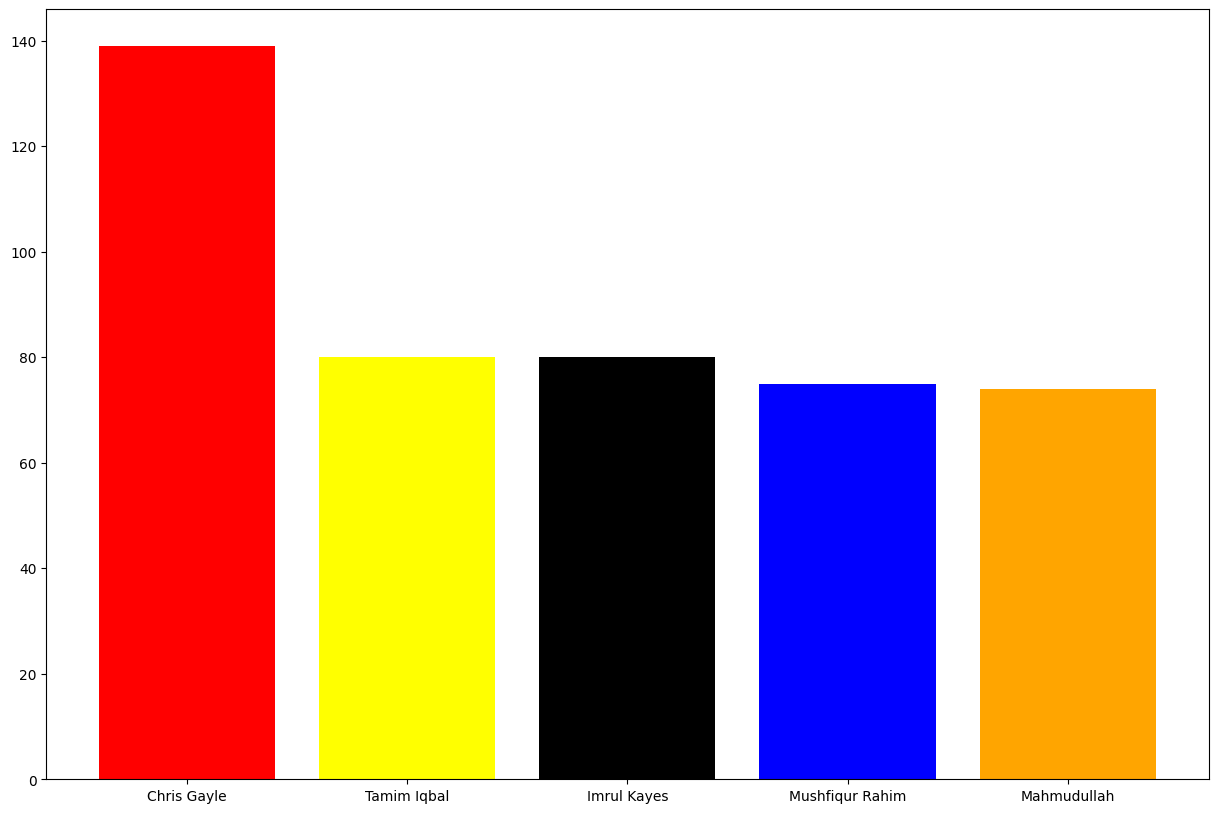

In [24]:
# Let's analyze data for score - sixes
analyzeBatsMan(df2, 'sixs')

## Analyzing dataset of Bowlers

In [25]:
df3 = pd.read_csv('/content/bowler.csv')
print(df3.shape)
df3.head()

(3601, 12)


,id,season,match_no,date,player_name,O,M,R,W,ECON,WD,NB
0,0,2011/12,Final,Feb 29 2012,Mashrafe Mortaza,2.0,0,17,0,8.50,0,0
1,0,2011/12,Final,Feb 29 2012,Azhar Mahmood,2.0,0,25,0,12.50,0,1
2,32,2011/12,1st,Feb 10 2012,Yasir Arafat,4.0,0,33,2,8.25,2,0
3,29,2011/12,4th,Feb 11 2012,Syed Rasel,3.0,0,33,0,11.00,2,0
4,28,2011/12,5th,Feb 12 2012,Dwayne Bravo,4.0,0,34,1,8.50,3,1


## Function to analyze data of Bowlers

In [26]:
def analyzeBowlers(dataFrame, col):
  dictionary = dict()

  # enlist all the unique data and count their frequency
  for i in dataFrame.index:
    if dataFrame[col][i] != '-':
      val = int(dataFrame[col][i])
      if dataFrame['player_name'][i] not in dictionary:
        dictionary[dataFrame['player_name'][i]] = val
      else:
        dictionary[dataFrame['player_name'][i]] += val

  print('Length of the dictionary: ', len(dictionary))

  # function call to plot the graph
  plotGraph(dictionary, col)

### Let's Start to Analyze Datasets w.r.t. Player Name.

Length of the dictionary:  263
Dictionary of W in descending order by value:  {'Shakib Al Hasan': 116, 'Rubel Hossain': 95, 'Mashrafe Mortaza': 84, 'Taskin Ahmed': 79, 'Shafiul Islam': 78, 'Farhad Reza': 68, 'Arafat Sunny': 66, 'Kevon Cooper': 63, 'Mohammad Nabi': 61, 'Mustafizur Rahman': 61, 'Thisara Perera': 59, 'Shahid Afridi': 57, 'Abu Jayed': 57, 'Nazmul Islam': 55, 'Andre Russell': 55, 'Dwayne Bravo': 53, 'Al-Amin Hossain': 52, 'Sohag Gazi': 52, 'Taijul Islam': 49, 'Mosharraf Hossain': 48, 'Kamrul Islam': 46, 'Mahmudullah': 45, 'Mehidy Hasan Miraz': 45, 'Abu Hider': 45, 'Mohammad Saifuddin': 45, 'Mohammad Sami': 44, 'Ravi Bopara': 42, 'Abul Hasan': 41, 'Junaid Khan': 38, 'Mohammad Amir': 38, 'Nasir Hossain': 37, 'Mahedi Hasan': 37, 'Sunzamul Islam': 35, 'Abdur Razzak': 34, 'Sohail Tanvir': 34, 'Alok Kapali': 33, 'Sunil Narine': 33, 'Mohammad Shahid': 33, 'Robbie Frylinck': 32, 'Enamul Haque jnr': 31, 'Shohidul Islam': 31, 'Nabil Samad': 30, 'Saqlain Sajib': 30, 'Azhar Mahmood': 2

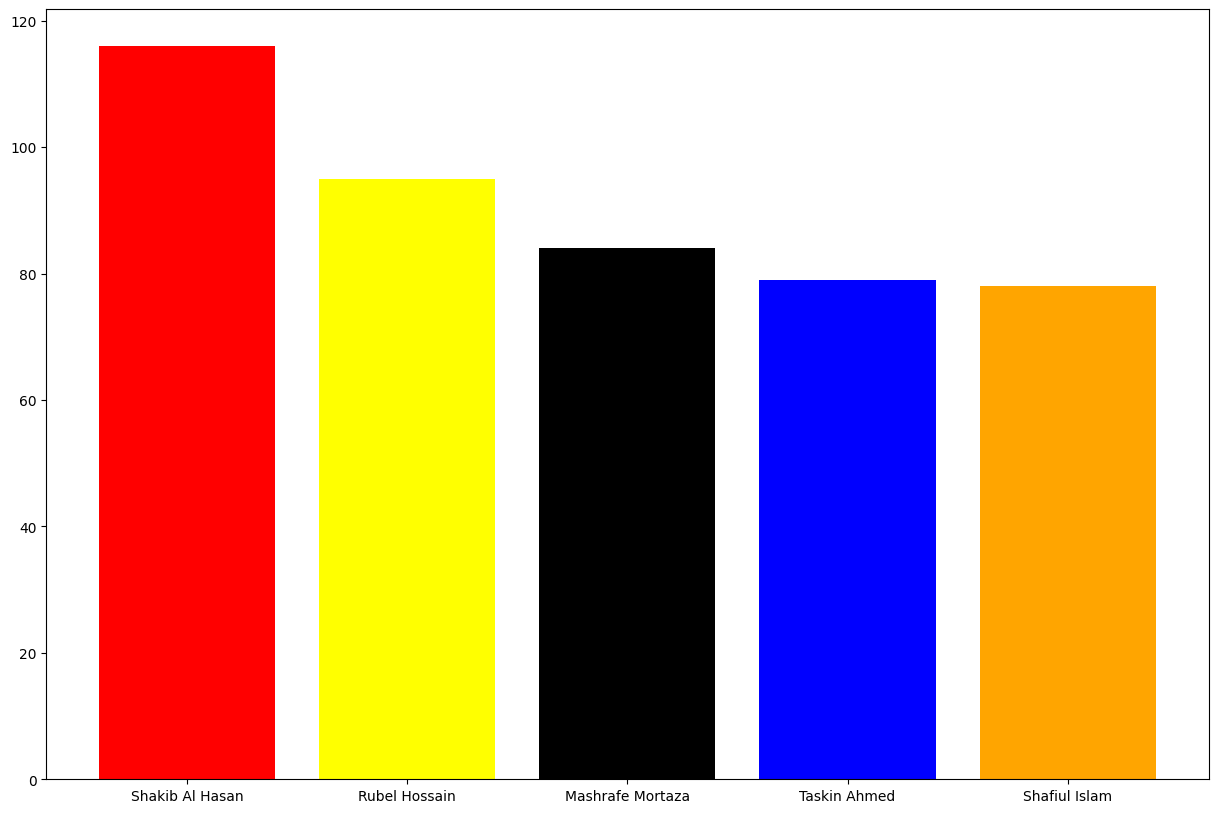

In [27]:
# Let's analyze data for wickets
analyzeBowlers(df3, 'W')

Length of the dictionary:  263
Dictionary of R in descending order by value:  {'Mashrafe Mortaza': 2143, 'Shafiul Islam': 2014, 'Shakib Al Hasan': 2002, 'Rubel Hossain': 1977, 'Farhad Reza': 1843, 'Al-Amin Hossain': 1609, 'Taskin Ahmed': 1551, 'Arafat Sunny': 1487, 'Nazmul Islam': 1442, 'Sohag Gazi': 1372, 'Mehidy Hasan Miraz': 1330, 'Taijul Islam': 1291, 'Andre Russell': 1244, 'Abu Jayed': 1223, 'Thisara Perera': 1193, 'Abu Hider': 1171, 'Mustafizur Rahman': 1104, 'Abul Hasan': 1095, 'Mohammad Nabi': 1079, 'Kamrul Islam': 1060, 'Dwayne Bravo': 1050, 'Sunzamul Islam': 1037, 'Mahmudullah': 1033, 'Nasir Hossain': 1005, 'Mahedi Hasan': 965, 'Mohammad Sami': 950, 'Shahid Afridi': 949, 'Mosharraf Hossain': 937, 'Nabil Samad': 927, 'Kevon Cooper': 883, 'Mohammad Saifuddin': 834, 'Abdur Razzak': 784, 'Saqlain Sajib': 776, 'Sohail Tanvir': 733, 'Sunil Narine': 702, 'Ravi Bopara': 693, 'Sohrawordi Shuvo': 672, 'Alok Kapali': 668, 'Monir Hossain': 667, 'Junaid Khan': 655, 'Shohidul Islam': 630, 

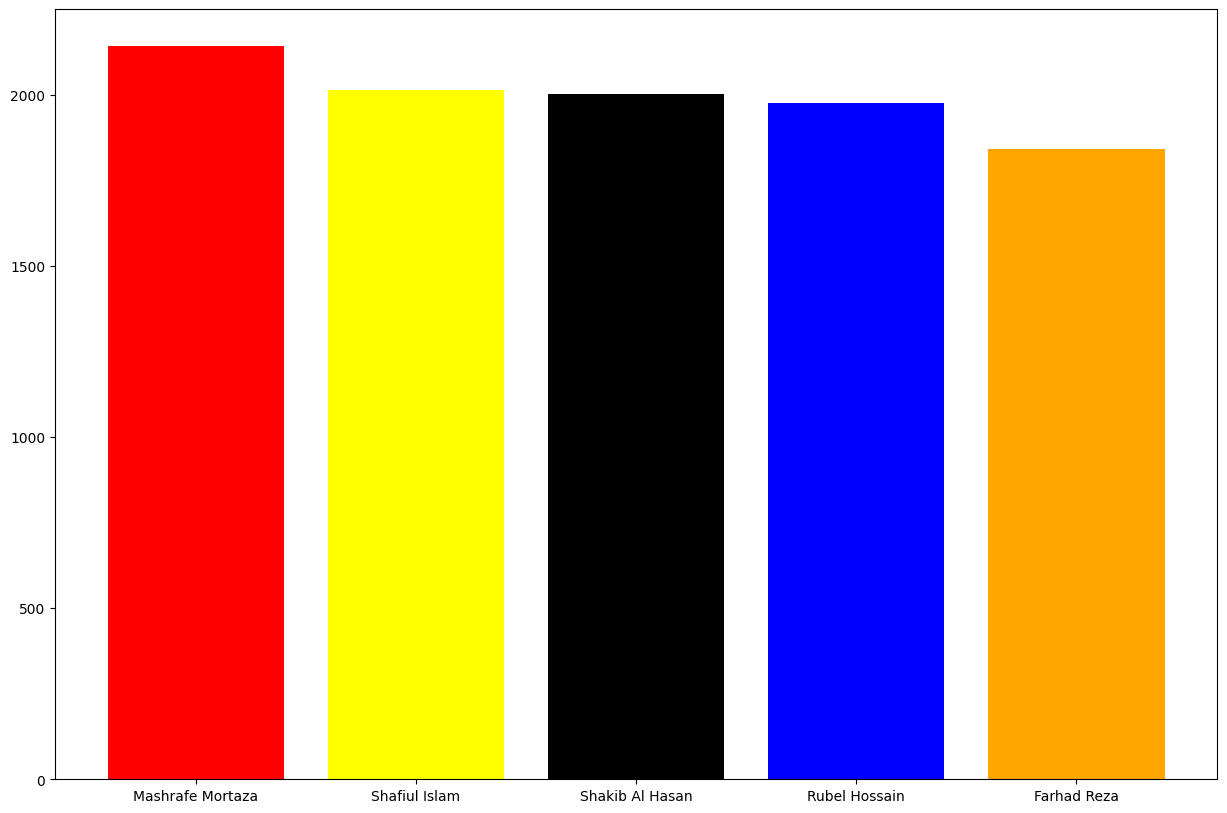

In [28]:
# Let's analyze data for runs
analyzeBowlers(df3, 'R')

Length of the dictionary:  263
Dictionary of O in descending order by value:  {'Mashrafe Mortaza': 311, 'Shakib Al Hasan': 302, 'Rubel Hossain': 249, 'Shafiul Islam': 237, 'Arafat Sunny': 211, 'Farhad Reza': 210, 'Nazmul Islam': 193, 'Sohag Gazi': 190, 'Taskin Ahmed': 181, 'Al-Amin Hossain': 181, 'Mehidy Hasan Miraz': 179, 'Taijul Islam': 177, 'Mustafizur Rahman': 160, 'Mohammad Nabi': 159, 'Andre Russell': 152, 'Mohammad Sami': 150, 'Abu Jayed': 150, 'Shahid Afridi': 148, 'Mosharraf Hossain': 148, 'Thisara Perera': 148, 'Mahmudullah': 145, 'Abu Hider': 145, 'Kevon Cooper': 139, 'Mahedi Hasan': 138, 'Nasir Hossain': 136, 'Nabil Samad': 134, 'Sunzamul Islam': 133, 'Dwayne Bravo': 125, 'Abul Hasan': 120, 'Sunil Narine': 120, 'Kamrul Islam': 120, 'Sohail Tanvir': 113, 'Abdur Razzak': 111, 'Ravi Bopara': 106, 'Saqlain Sajib': 105, 'Mohammad Saifuddin': 102, 'Junaid Khan': 94, 'Monir Hossain': 93, 'Mohammad Amir': 93, 'Enamul Haque jnr': 86, 'Sohrawordi Shuvo': 86, 'Mohammad Shahid': 84, 'A

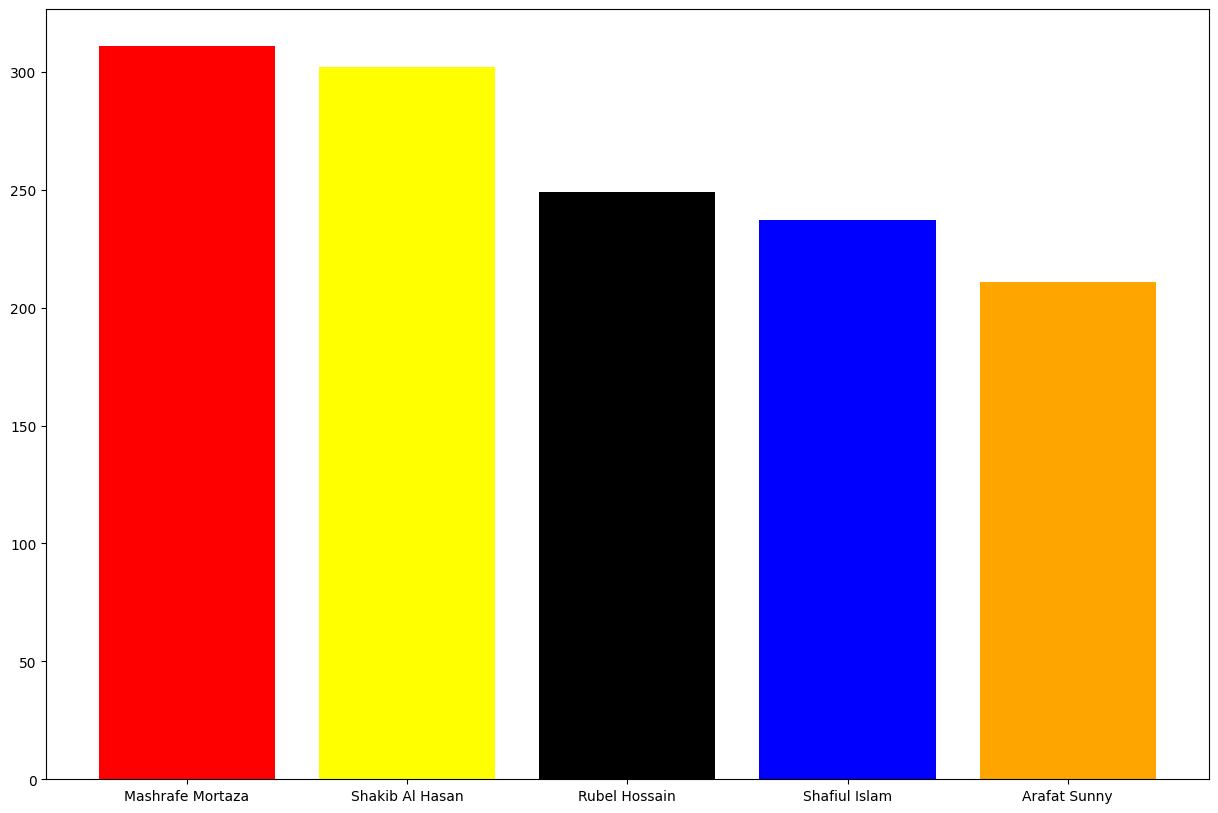

In [29]:
# Let's analyze data for overs
analyzeBowlers(df3, 'O')

### Analysis of the Bangladesh Players Completed!

## Let's Start building the model

In [30]:
data = df[['team_1', 'team_2', 'toss_winner', 'toss_decision', 'venue', 'winner']].copy()
print('Shape', data.shape)
data.head()

Shape (311, 6)


,team_1,team_2,toss_winner,toss_decision,venue,winner
0,Barisal Burners,Dhaka Gladiators,Dhaka Gladiators,field first,"Shere Bangla National Stadium, Mirpur",Dhaka
1,Khulna Royal Bengals,Dhaka Gladiators,Khulna Royal Bengals,bat first,"Shere Bangla National Stadium, Mirpur",Khulna
2,Barisal Burners,Khulna Royal Bengals,Khulna Royal Bengals,field first,"Shere Bangla National Stadium, Mirpur",Khulna
3,Barisal Burners,Duronto Rajshahi,Barisal Burners,bat first,"Shere Bangla National Stadium, Mirpur",Barisal
4,Khulna Royal Bengals,Chittagong Kings,Khulna Royal Bengals,bat first,"Shere Bangla National Stadium, Mirpur",Chittagong


### Performing Data Filtering and Feature Engineering

In [31]:
label_encoder = LabelEncoder()

data['toss_decision_encoded'] = label_encoder.fit_transform(data['toss_decision'])
data.drop(columns=['toss_decision'], inplace=True)

data.head()

,team_1,team_2,toss_winner,venue,winner,toss_decision_encoded
0,Barisal Burners,Dhaka Gladiators,Dhaka Gladiators,"Shere Bangla National Stadium, Mirpur",Dhaka,1
1,Khulna Royal Bengals,Dhaka Gladiators,Khulna Royal Bengals,"Shere Bangla National Stadium, Mirpur",Khulna,0
2,Barisal Burners,Khulna Royal Bengals,Khulna Royal Bengals,"Shere Bangla National Stadium, Mirpur",Khulna,1
3,Barisal Burners,Duronto Rajshahi,Barisal Burners,"Shere Bangla National Stadium, Mirpur",Barisal,0
4,Khulna Royal Bengals,Chittagong Kings,Khulna Royal Bengals,"Shere Bangla National Stadium, Mirpur",Chittagong,0


In [32]:
# Toss winner -> Winner
data['toss_vs_winner'] = 0

for i in data.index:
    if data['toss_winner'][i].split(' ')[0] == data['winner'][i]:
        data.at[i, 'toss_vs_winner'] = 1
    else:
        data.at[i, 'toss_vs_winner'] = 0

data.drop(columns=['toss_winner'], inplace=True)
data.head()


,team_1,team_2,venue,winner,toss_decision_encoded,toss_vs_winner
0,Barisal Burners,Dhaka Gladiators,"Shere Bangla National Stadium, Mirpur",Dhaka,1,1
1,Khulna Royal Bengals,Dhaka Gladiators,"Shere Bangla National Stadium, Mirpur",Khulna,0,1
2,Barisal Burners,Khulna Royal Bengals,"Shere Bangla National Stadium, Mirpur",Khulna,1,1
3,Barisal Burners,Duronto Rajshahi,"Shere Bangla National Stadium, Mirpur",Barisal,0,1
4,Khulna Royal Bengals,Chittagong Kings,"Shere Bangla National Stadium, Mirpur",Chittagong,0,0


In [33]:
label_encoder = LabelEncoder()

data['venue_encoded'] = label_encoder.fit_transform(data['venue'])
data.drop(columns=['venue'], inplace=True)

data.head()

,team_1,team_2,winner,toss_decision_encoded,toss_vs_winner,venue_encoded
0,Barisal Burners,Dhaka Gladiators,Dhaka,1,1,2
1,Khulna Royal Bengals,Dhaka Gladiators,Khulna,0,1,2
2,Barisal Burners,Khulna Royal Bengals,Khulna,1,1,2
3,Barisal Burners,Duronto Rajshahi,Barisal,0,1,2
4,Khulna Royal Bengals,Chittagong Kings,Chittagong,0,0,2


In [34]:
data['venue_encoded'].unique()

array([2, 5, 3, 4, 1, 0])

In [35]:
for i in data.index:
    data.loc[i, 'team_1'] = data['team_1'][i].split(' ')[0]

for i in data.index:
    data.loc[i, 'team_2'] = data['team_2'][i].split(' ')[0]

data.head()

,team_1,team_2,winner,toss_decision_encoded,toss_vs_winner,venue_encoded
0,Barisal,Dhaka,Dhaka,1,1,2
1,Khulna,Dhaka,Khulna,0,1,2
2,Barisal,Khulna,Khulna,1,1,2
3,Barisal,Duronto,Barisal,0,1,2
4,Khulna,Chittagong,Chittagong,0,0,2


In [36]:
teamDict = dict()

for i in range(len(uniqueTeamNames)):
  uniqueTeamNames[i] = str(uniqueTeamNames[i])
  uniqueTeamNames[i] = uniqueTeamNames[i].split(' ')[0]
  teamDict[uniqueTeamNames[i]] = i+1

for i in data.index:
  data.loc[i, 'team_1'] = teamDict[data['team_1'][i]]
  data.loc[i, 'team_2'] = teamDict[data['team_2'][i]]
  data.loc[i, 'winner'] = teamDict[data['winner'][i]]

data.head()

,team_1,team_2,winner,toss_decision_encoded,toss_vs_winner,venue_encoded
0,28,26,26,1,1,2
1,27,26,27,0,1,2
2,28,27,27,1,1,2
3,28,6,28,0,1,2
4,27,29,29,0,0,2


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   team_1                 311 non-null    object
 1   team_2                 311 non-null    object
 2   winner                 311 non-null    object
 3   toss_decision_encoded  311 non-null    int64 
 4   toss_vs_winner         311 non-null    int64 
 5   venue_encoded          311 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 14.7+ KB


In [38]:
data['team_1'] = pd.to_numeric(data.team_1)

In [39]:
data['team_2'] = pd.to_numeric(data['team_2'])

In [40]:
data['winner'] = pd.to_numeric(data['winner'])

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   team_1                 311 non-null    int64
 1   team_2                 311 non-null    int64
 2   winner                 311 non-null    int64
 3   toss_decision_encoded  311 non-null    int64
 4   toss_vs_winner         311 non-null    int64
 5   venue_encoded          311 non-null    int64
dtypes: int64(6)
memory usage: 14.7 KB


In [42]:
x = data.drop('winner', axis=1)
y = data['winner']

print(x.shape)
print(y.shape)

(311, 5)
(311,)


In [43]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

print('Training Dataset: ', xtrain.shape, ytrain.shape)
print('Testing Dataset: ', xtest.shape, ytest.shape)

Training Dataset:  (248, 5) (248,)
Testing Dataset:  (63, 5) (63,)


### So, Let's train the Linear Regression Model

In [44]:
# DataFrame to store the mse and r2 score of the different models

results = pd.DataFrame(columns=['Model', 'MSE', 'R2'])

In [45]:
lr_model = LinearRegression()
lr_model.fit(xtrain, ytrain)

LinearRegression()

In [46]:
ypred = lr_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['Linear Regression', mse, r2]

Mean Squared Error: 26.916888278949617
R2 Score: 0.12573749505596643


### Now, let's train the Decision Tree Regression Model

In [47]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)

DecisionTreeRegressor()

In [48]:
ypred = dtr_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['Decision Tree Regression', mse, r2]

Mean Squared Error: 29.04453262786596
R2 Score: 0.05663145059657304


### Now, let's train the Ridge Regression Model

In [49]:
ridge_model = Ridge()
ridge_model.fit(xtrain, ytrain)

Ridge()

In [50]:
ypred = ridge_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['Ridge Regression', mse, r2]

Mean Squared Error: 26.813980552925734
R2 Score: 0.12907994554278945


### Now, let's train the Random Forest Regression Model

In [51]:
rfr_model = RandomForestRegressor()
rfr_model.fit(xtrain, ytrain)

RandomForestRegressor()

In [52]:
ypred = rfr_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['Random Forest Regression', mse, r2]

Mean Squared Error: 19.35598394888564
R2 Score: 0.3713162220893379


### Now, let's train the Gradient Boosting Regression Model

In [53]:
gbr_model = GradientBoostingRegressor()
gbr_model.fit(xtrain, ytrain)

GradientBoostingRegressor()

In [54]:
ypred = gbr_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['Gradient Boosting Regression', mse, r2]

Mean Squared Error: 19.420493964865646
R2 Score: 0.36922093204019923


### Now, let's train the XG Boost Regression Model

In [55]:
xg_model = XGBRegressor(objective ='reg:squarederror')
xg_model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
ypred = xg_model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

results.loc[len(results)] = ['XG Boost Regression', mse, r2]

Mean Squared Error: 21.349168321235965
R2 Score: 0.30657744752790117


## Let's Build Neural Network and train the model

In [57]:
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(xtrain.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(xtrain_scaled, ytrain, epochs=1000, batch_size=32, validation_data=(xtest_scaled, ytest))


Epoch 1/1000
8/8 [==============================] - 1s 35ms/step - loss: 1228.0503 - val_loss: 1228.4310
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 1177.1763 - val_loss: 1160.0342
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 1093.6628 - val_loss: 1043.5067
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 952.9269 - val_loss: 852.3802
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 732.9378 - val_loss: 573.0662
Epoch 6/1000
8/8 [==============================] - 0s 10ms/step - loss: 441.8173 - val_loss: 268.2645
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 191.3764 - val_loss: 127.1966
Epoch 8/1000
8/8 [==============================] - 0s 7ms/step - loss: 125.0085 - val_loss: 123.0217
Epoch 9/1000
8/8 [==============================] - 0s 9ms/step - loss: 105.4655 - val_loss: 81.5321
Epoch 10/1000
8/8 [==============================] - 0s 10ms/step - loss: 7

In [58]:
predictions = model.predict(xtest_scaled)

mse = mean_squared_error(ytest, predictions)
r2 = r2_score(ytest, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

results.loc[len(results)] = ['Deep Neural Network', mse, r2]


2/2 [==============================] - 0s 6ms/step
Mean Squared Error: 27.758215907943057
R2 Score: 0.0984111119770702


### Let's Print the result in ascending order of MSE of all the models

In [59]:
results.sort_values(by='MSE', ascending=True)

,Model,MSE,R2
3,Random Forest Regression,19.355984,0.371316
4,Gradient Boosting Regression,19.420494,0.369221
5,XG Boost Regression,21.349168,0.306577
2,Ridge Regression,26.813981,0.129080
0,Linear Regression,26.916888,0.125737
6,Deep Neural Network,27.758216,0.098411
1,Decision Tree Regression,29.044533,0.056631


- Here we can see that R2 Score and Mean Absolute Error is best for Random Forest Regression.

### Random Forest Regression is best fit for predicting bangladesh premier league winning team, let's visualize its results.

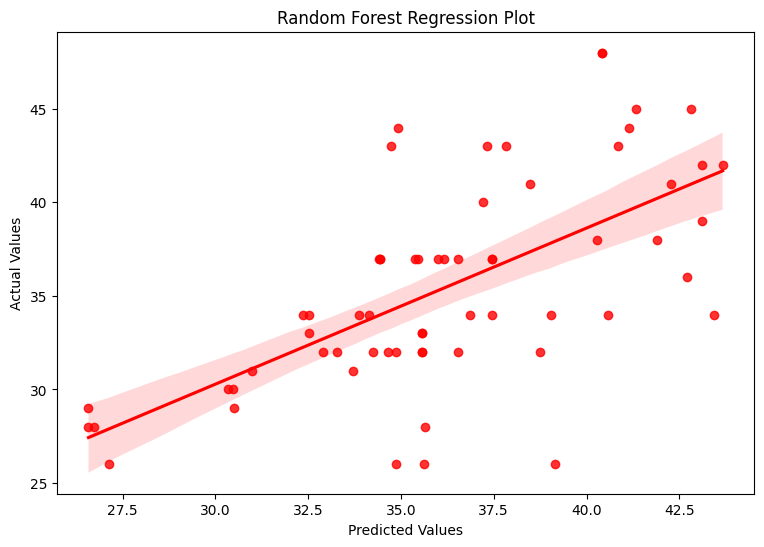

In [60]:
import seaborn as sb

ypred = rfr_model.predict(xtest)

# Creating regression plot to visualize the model performance
plt.figure(figsize=(9,6))

sb.regplot(x=ypred, y=ytest, color='red')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Regression Plot')

plt.show()

In [61]:
plot_df = pd.DataFrame({'pred':ypred.flatten() , 'actual':ytest})

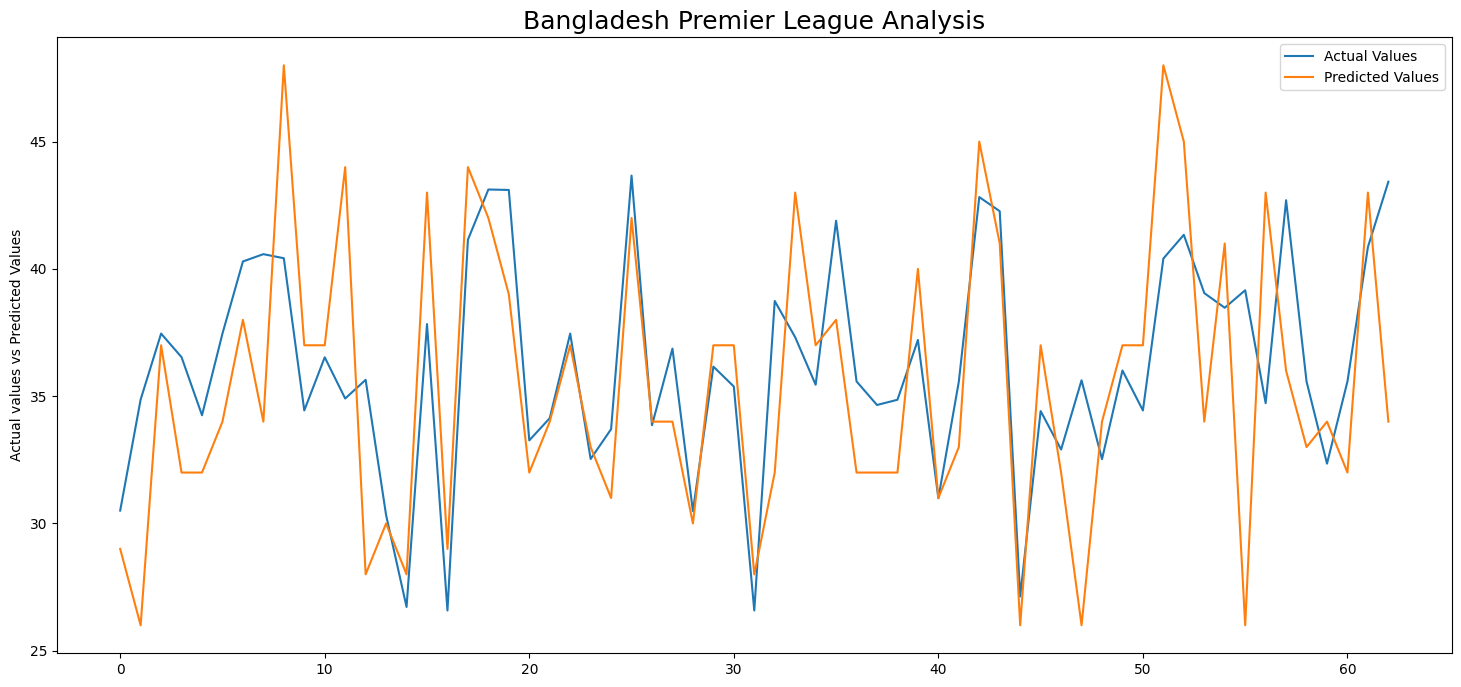

In [62]:
# Creating plot for actual vs Predicted values
plt.figure(figsize=(18,8))

plt.plot(plot_df['pred'].tolist(), label='Actual Values')
plt.plot(plot_df['actual'].tolist(), label='Predicted Values')

plt.ylabel('Actual values vs Predicted Values')
plt.title('Bangladesh Premier League Analysis', fontsize=18)

plt.legend()
plt.show()